# XGBoost Most Important Features

In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb

import matplotlib.pyplot as plt 
import seaborn as sns
import ppscore as pps

## Read in and Split Data

In [3]:
# read in data
data = pd.read_csv('../data/unemployment_data.csv')
data.head()

,initclaims_rate_regular,FIPS,State,County,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,...,% Below Poverty,Median Household Income,% No College Degree,Unemployment Rate,% Not in Labor Force,% Jobs in Leisure and Hospitality,% Part-time,% Self-Employed,Presence of Water Violation (dummy Y/N),Other Primary Care Provider Ratio (:1)
0,26.0512,1001,Alabama,Autauga,791,8128.59119,20.882987,4.743889,4.654031,8.619529,...,12.1,58233,16.107796,2.7,40.454576,14.216260,39.604710,7.283256,0,2527
1,30.8648,1003,Alabama,Baldwin,2967,7354.12253,17.509134,4.224519,4.304056,8.345003,...,10.1,59871,21.044656,2.7,43.511495,20.823355,40.364194,12.669969,0,1787
2,24.5891,1005,Alabama,Barbour,472,10253.57340,29.591802,5.430279,5.185594,11.474559,...,27.1,35972,7.609664,3.8,58.630549,9.248695,54.696722,9.675502,0,1914
3,35.7501,1007,Alabama,Bibb,471,11977.53948,19.439724,4.591482,4.551699,10.308710,...,20.3,47918,6.451014,3.1,53.033744,4.345937,52.112959,7.547395,0,896
4,15.1614,1009,Alabama,Blount,1085,11335.07113,21.745293,4.860808,4.891455,7.604563,...,16.3,52902,8.625066,2.7,44.821051,10.342057,47.550659,7.815851,0,4449


In [4]:
data["Hospitals per 100,000"] = round((data["Number of Hospitals"]/data.Population) * 100000, 1)

In [5]:
X = data.drop(["FIPS", "initclaims_rate_regular", "Hospitals per 100,000", "State", "County", "Number of Hospitals"], axis=1)
y = pd.DataFrame(data["Hospitals per 100,000"])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
len(X.columns)

97

## XGBoost and Feature Importance

In [8]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [9]:
"""
Hyperparameter Tuning from 
https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
"""

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
    'eval_metric':"rmse"
}

In [10]:
num_boost_round = 999

In [11]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:6.67235
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:5.95612
[2]	Test-rmse:5.49101
[3]	Test-rmse:5.27918
[4]	Test-rmse:5.16967
[5]	Test-rmse:4.98790
[6]	Test-rmse:4.94775
[7]	Test-rmse:4.89032
[8]	Test-rmse:4.88746
[9]	Test-rmse:4.86679
[10]	Test-rmse:4.88523
[11]	Test-rmse:4.92010
[12]	Test-rmse:4.91032
[13]	Test-rmse:4.92786
[14]	Test-rmse:4.94083
[15]	Test-rmse:4.92017
[16]	Test-rmse:4.92665
[17]	Test-rmse:4.94162
[18]	Test-rmse:4.95325
[19]	Test-rmse:4.95601
Stopping. Best iteration:
[9]	Test-rmse:4.86679



In [12]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,6.444012,0.169830,7.143790,1.340684
1,5.053401,0.133969,6.487700,1.258188
2,4.068378,0.111040,6.089707,1.258978
3,3.321610,0.105276,5.907743,1.186794
4,2.801650,0.123462,5.790979,1.136772
5,2.418956,0.120665,5.668241,1.113990
6,2.139142,0.129264,5.588784,1.049764
7,1.934126,0.146311,5.569206,1.030389
8,1.750219,0.157381,5.561365,1.012684
9,1.643110,0.157135,5.533906,0.991371


In [13]:
cv_results['test-rmse-mean'].min()

5.533906

## Tune max_depth and min_child_weight

In [14]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [15]:
# Define initial best params and rmse
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best rmse
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=9, min_child_weight=5
	rmse 5.4400922000000005 for 10 rounds
CV with max_depth=9, min_child_weight=6
	rmse 5.3672813999999995 for 10 rounds
CV with max_depth=9, min_child_weight=7
	rmse 5.440576399999999 for 12 rounds
CV with max_depth=10, min_child_weight=5
	rmse 5.5536389999999995 for 20 rounds
CV with max_depth=10, min_child_weight=6
	rmse 5.2695454 for 16 rounds
CV with max_depth=10, min_child_weight=7
	rmse 5.3804944 for 8 rounds
CV with max_depth=11, min_child_weight=5
	rmse 5.5093049999999995 for 22 rounds
CV with max_depth=11, min_child_weight=6
	rmse 5.3666377999999995 for 14 rounds
CV with max_depth=11, min_child_weight=7
	rmse 5.410599 for 16 rounds
Best params: 10, 6, rmse: 5.2695454


In [17]:
params['max_depth'] = 10
params['min_child_weight'] = 6

## Tune subsample and colsample

In [18]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [19]:
min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
	rmse 5.2695452000000005 for 16 rounds
CV with subsample=1.0, colsample=0.9
	rmse 5.3524966 for 23 rounds
CV with subsample=1.0, colsample=0.8
	rmse 5.3348455999999995 for 14 rounds
CV with subsample=1.0, colsample=0.7
	rmse 5.4013612 for 12 rounds
CV with subsample=0.9, colsample=1.0
	rmse 5.5353614 for 15 rounds
CV with subsample=0.9, colsample=0.9
	rmse 5.325742400000001 for 18 rounds
CV with subsample=0.9, colsample=0.8
	rmse 5.4402776 for 17 rounds
CV with subsample=0.9, colsample=0.7
	rmse 5.4232005999999995 for 9 rounds
CV with subsample=0.8, colsample=1.0
	rmse 5.754737 for 5 rounds
CV with subsample=0.8, colsample=0.9
	rmse 5.3704374 for 11 rounds
CV with subsample=0.8, colsample=0.8
	rmse 5.8521 for 13 rounds
CV with subsample=0.8, colsample=0.7
	rmse 5.749691 for 13 rounds
CV with subsample=0.7, colsample=1.0
	rmse 5.6003262 for 18 rounds
CV with subsample=0.7, colsample=0.9
	rmse 5.7954224 for 5 rounds
CV with subsample=0.7, colsample=0.

In [20]:
params['subsample'] = 1.0
params['colsample_bytree'] = 1.0

## Tune eta

In [21]:
min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=42, nfold=5, metrics=['rmse'], early_stopping_rounds=10)
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, rmse: {}".format(best_params, min_rmse))

CV with eta=0.3
	rmse 5.269545 for 16 rounds

CV with eta=0.2
	rmse 5.2259952 for 15 rounds

CV with eta=0.1
	rmse 5.208633600000001 for 71 rounds

CV with eta=0.05
	rmse 5.2719404 for 119 rounds

CV with eta=0.01
	rmse 5.2662568 for 361 rounds

CV with eta=0.005
	rmse 5.2962706 for 668 rounds

Best params: 0.1, rmse: 5.208633600000001


In [22]:
params['eta'] = 0.1

In [23]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:7.27168
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:6.86851
[2]	Test-rmse:6.58862
[3]	Test-rmse:6.30420
[4]	Test-rmse:6.03134
[5]	Test-rmse:5.81860
[6]	Test-rmse:5.64309
[7]	Test-rmse:5.50719
[8]	Test-rmse:5.35482
[9]	Test-rmse:5.25662
[10]	Test-rmse:5.20050
[11]	Test-rmse:5.18325
[12]	Test-rmse:5.18067
[13]	Test-rmse:5.13434
[14]	Test-rmse:5.05956
[15]	Test-rmse:5.08847
[16]	Test-rmse:5.03948
[17]	Test-rmse:5.00661
[18]	Test-rmse:4.97523
[19]	Test-rmse:4.96345
[20]	Test-rmse:4.93895
[21]	Test-rmse:4.91943
[22]	Test-rmse:4.93976
[23]	Test-rmse:4.94379
[24]	Test-rmse:4.94835
[25]	Test-rmse:4.93170
[26]	Test-rmse:4.91689
[27]	Test-rmse:4.90395
[28]	Test-rmse:4.90654
[29]	Test-rmse:4.89324
[30]	Test-rmse:4.89954
[31]	Test-rmse:4.88672
[32]	Test-rmse:4.89155
[33]	Test-rmse:4.89482
[34]	Test-rmse:4.89846
[35]	Test-rmse:4.90214
[36]	Test-rmse:4.91029
[37]	Test-rmse:4.91891
[38]	Test-rmse:4.92063
[39]	Test-rmse:4.92161
[40]	Test-rmse:4.92200
[41]	Test-

In [24]:
print("Best RMSE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

Best RMSE: 4.89 in 32 rounds


## Get and save best model

In [25]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-rmse:7.27168
[1]	Test-rmse:6.86851
[2]	Test-rmse:6.58862
[3]	Test-rmse:6.30420
[4]	Test-rmse:6.03134
[5]	Test-rmse:5.81860
[6]	Test-rmse:5.64309
[7]	Test-rmse:5.50719
[8]	Test-rmse:5.35482
[9]	Test-rmse:5.25662
[10]	Test-rmse:5.20050
[11]	Test-rmse:5.18325
[12]	Test-rmse:5.18067
[13]	Test-rmse:5.13434
[14]	Test-rmse:5.05956
[15]	Test-rmse:5.08847
[16]	Test-rmse:5.03948
[17]	Test-rmse:5.00661
[18]	Test-rmse:4.97523
[19]	Test-rmse:4.96345
[20]	Test-rmse:4.93895
[21]	Test-rmse:4.91943
[22]	Test-rmse:4.93976
[23]	Test-rmse:4.94379
[24]	Test-rmse:4.94835
[25]	Test-rmse:4.93170
[26]	Test-rmse:4.91689
[27]	Test-rmse:4.90395
[28]	Test-rmse:4.90654
[29]	Test-rmse:4.89324
[30]	Test-rmse:4.89954
[31]	Test-rmse:4.88672


In [26]:
best_model.save_model("my_model.model")

In [27]:
(mean_squared_error(best_model.predict(dtest), y_test))**.5

4.886720442842323

## Feature Importance

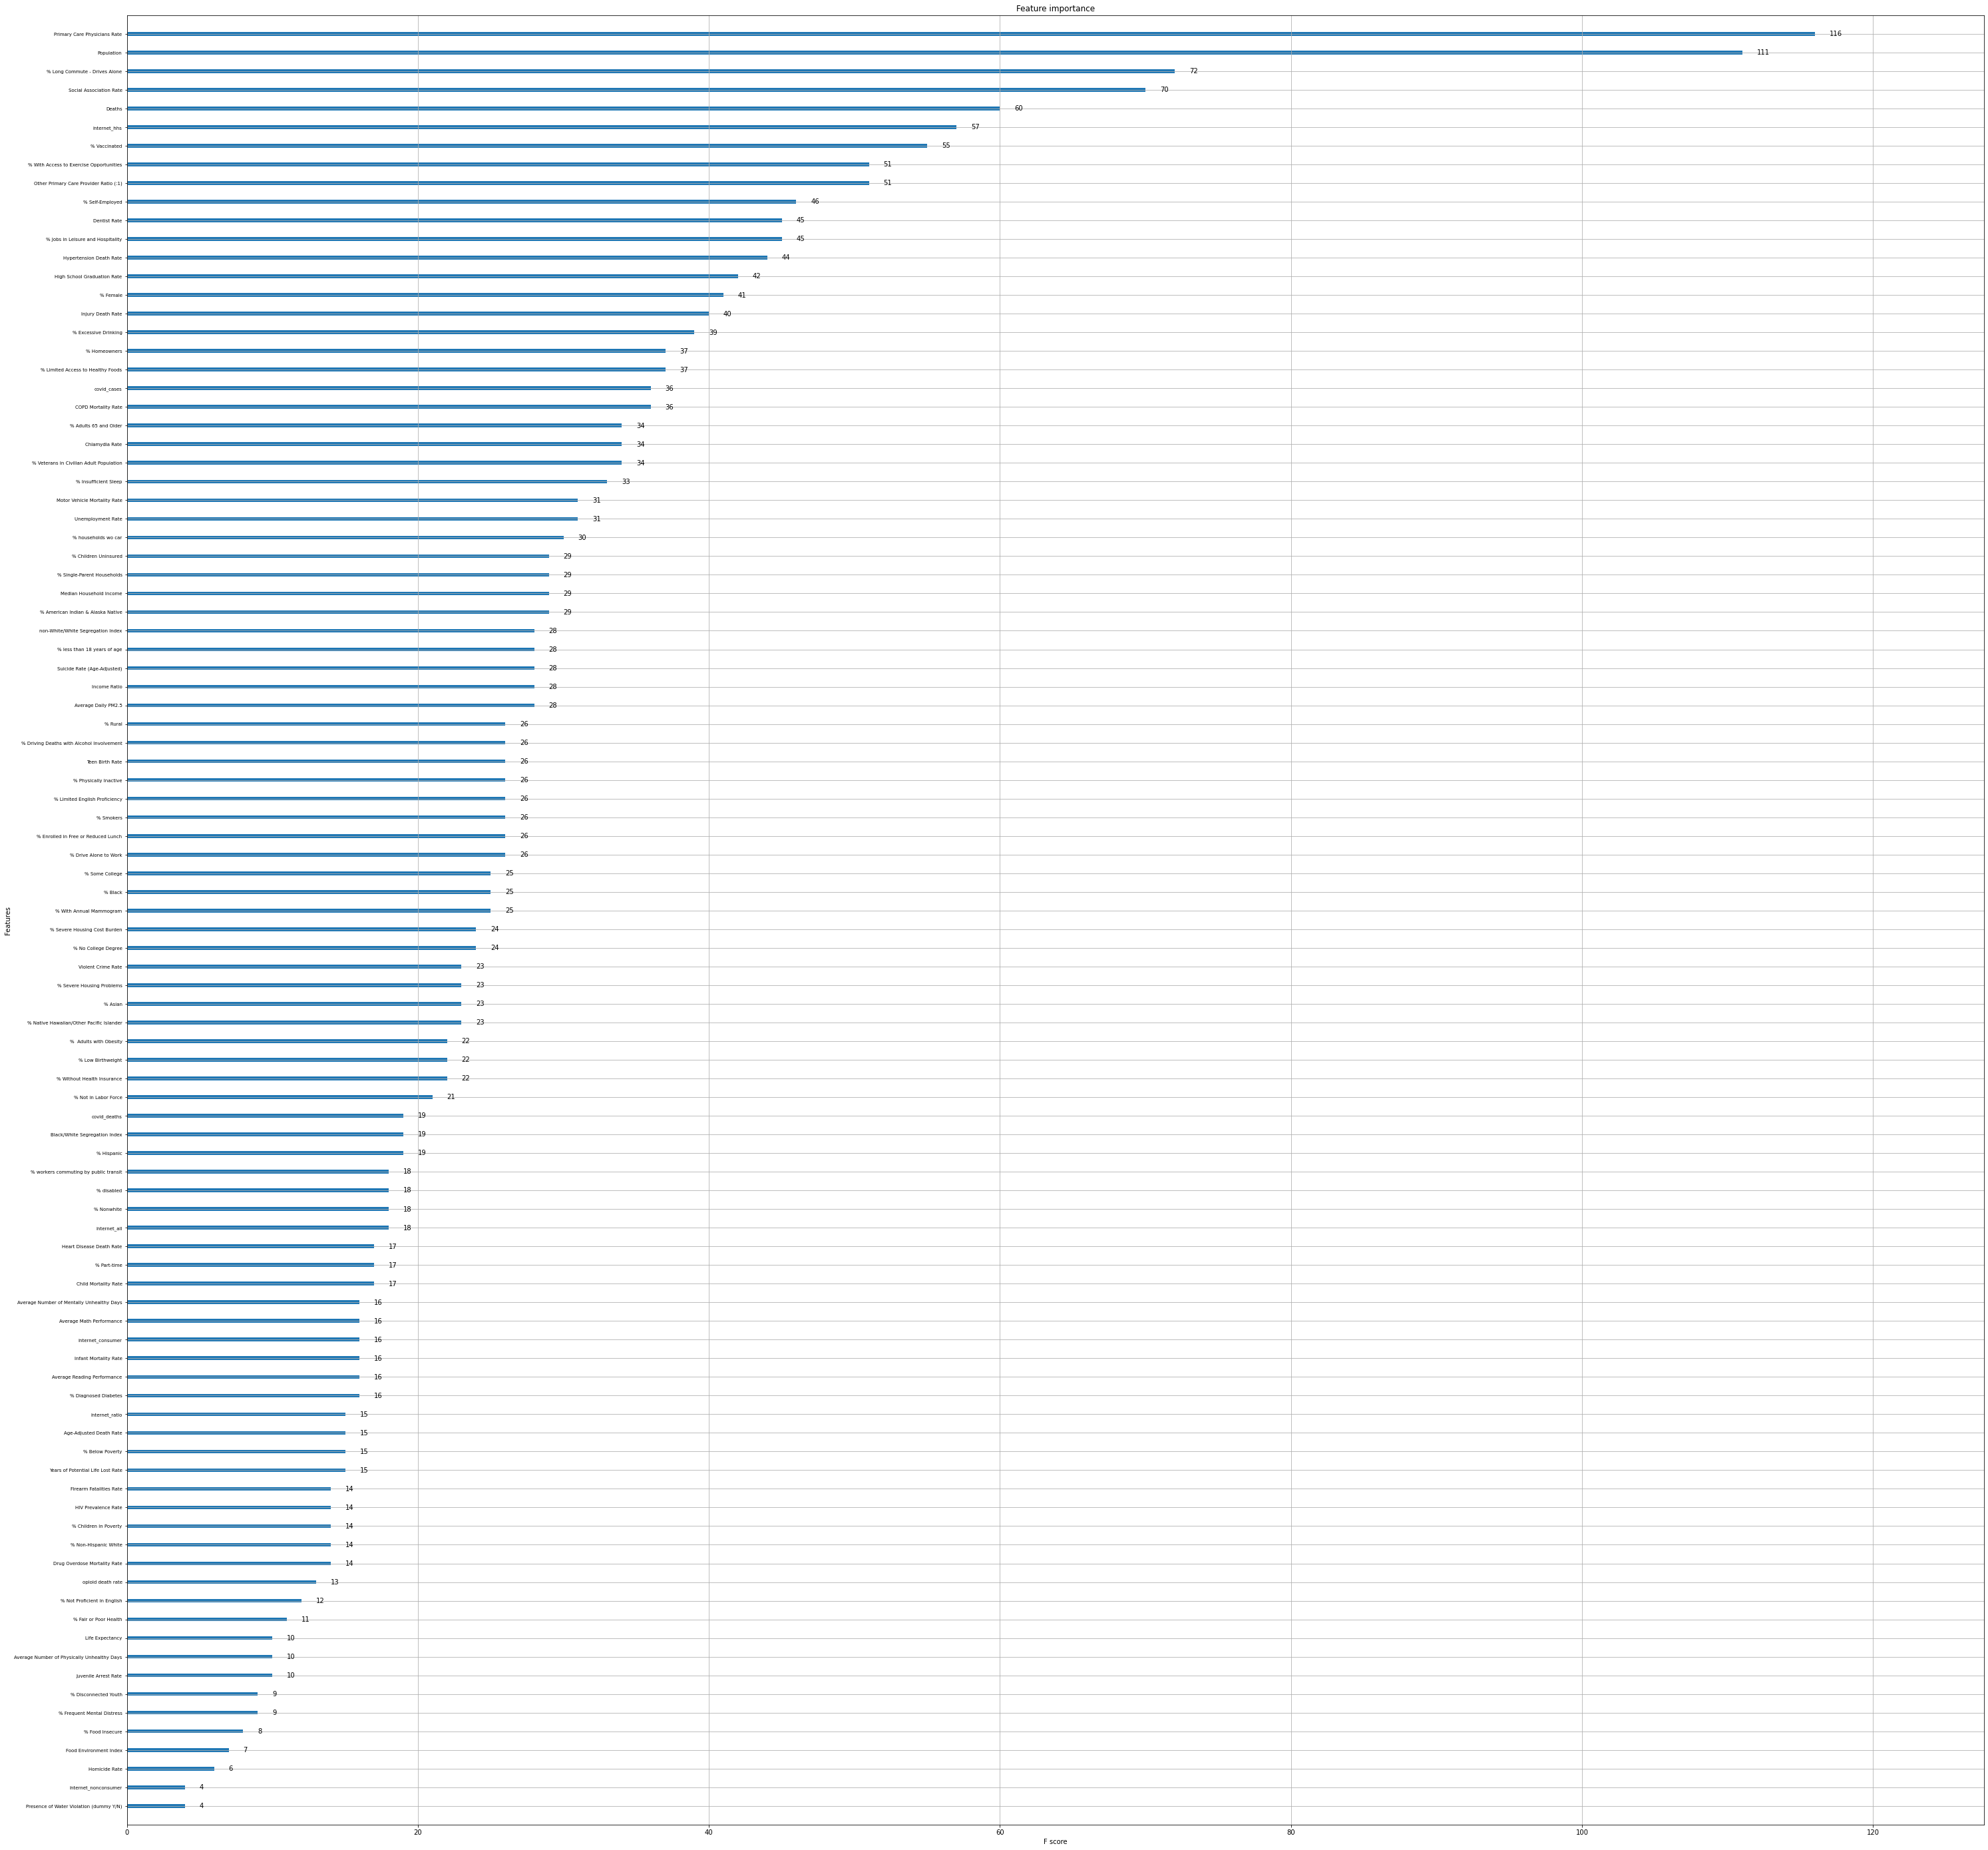

In [29]:
xgb.plot_importance(best_model)
plt.rcParams['figure.figsize'] = [50, 50]
plt.yticks(size = 7)
plt.show()

The top 9 features (F-score > 50):
1. Primary Care Physicians Rate
2. Population
3. % Long Commute - Drives Alone
4. Social Association Rate
5. Deaths
6. internet_hhs
7. % Vaccinated
8. % With Access to Exercise Opportunities
9. Other Primary Care Provider Ratio (:1)

## Correlation

In [30]:
X_x = X.filter(['Primary Care Physicians Rate', 'Population', '% Long Commute - Drives Alone',
                'Social Association Rate', 'Deaths', 'internet_hhs', '% Vaccinated', 
                '% With Access to Exercise Opportunities', 'Other Primary Care Provider Ratio (:1)'])

In [31]:
Correlation_Matrix=X_x.corr().abs()
Correlation_Matrix

,Primary Care Physicians Rate,Population,% Long Commute - Drives Alone,Social Association Rate,Deaths,internet_hhs,% Vaccinated,% With Access to Exercise Opportunities,Other Primary Care Provider Ratio (:1)
Primary Care Physicians Rate,1.000000,0.205878,0.295265,0.108428,0.214859,0.223770,0.253714,0.436146,0.313423
Population,0.205878,1.000000,0.142181,0.138638,0.977655,0.995757,0.102351,0.284106,0.087896
% Long Commute - Drives Alone,0.295265,0.142181,1.000000,0.275561,0.131775,0.140808,0.010552,0.197410,0.274386
Social Association Rate,0.108428,0.138638,0.275561,1.000000,0.135560,0.131868,0.123553,0.025216,0.074102
Deaths,0.214859,0.977655,0.131775,0.135560,1.000000,0.983036,0.113156,0.300501,0.107075
internet_hhs,0.223770,0.995757,0.140808,0.131868,0.983036,1.000000,0.115925,0.298122,0.097219
% Vaccinated,0.253714,0.102351,0.010552,0.123553,0.113156,0.115925,1.000000,0.341780,0.019231
% With Access to Exercise Opportunities,0.436146,0.284106,0.197410,0.025216,0.300501,0.298122,0.341780,1.000000,0.227884
Other Primary Care Provider Ratio (:1),0.313423,0.087896,0.274386,0.074102,0.107075,0.097219,0.019231,0.227884,1.000000


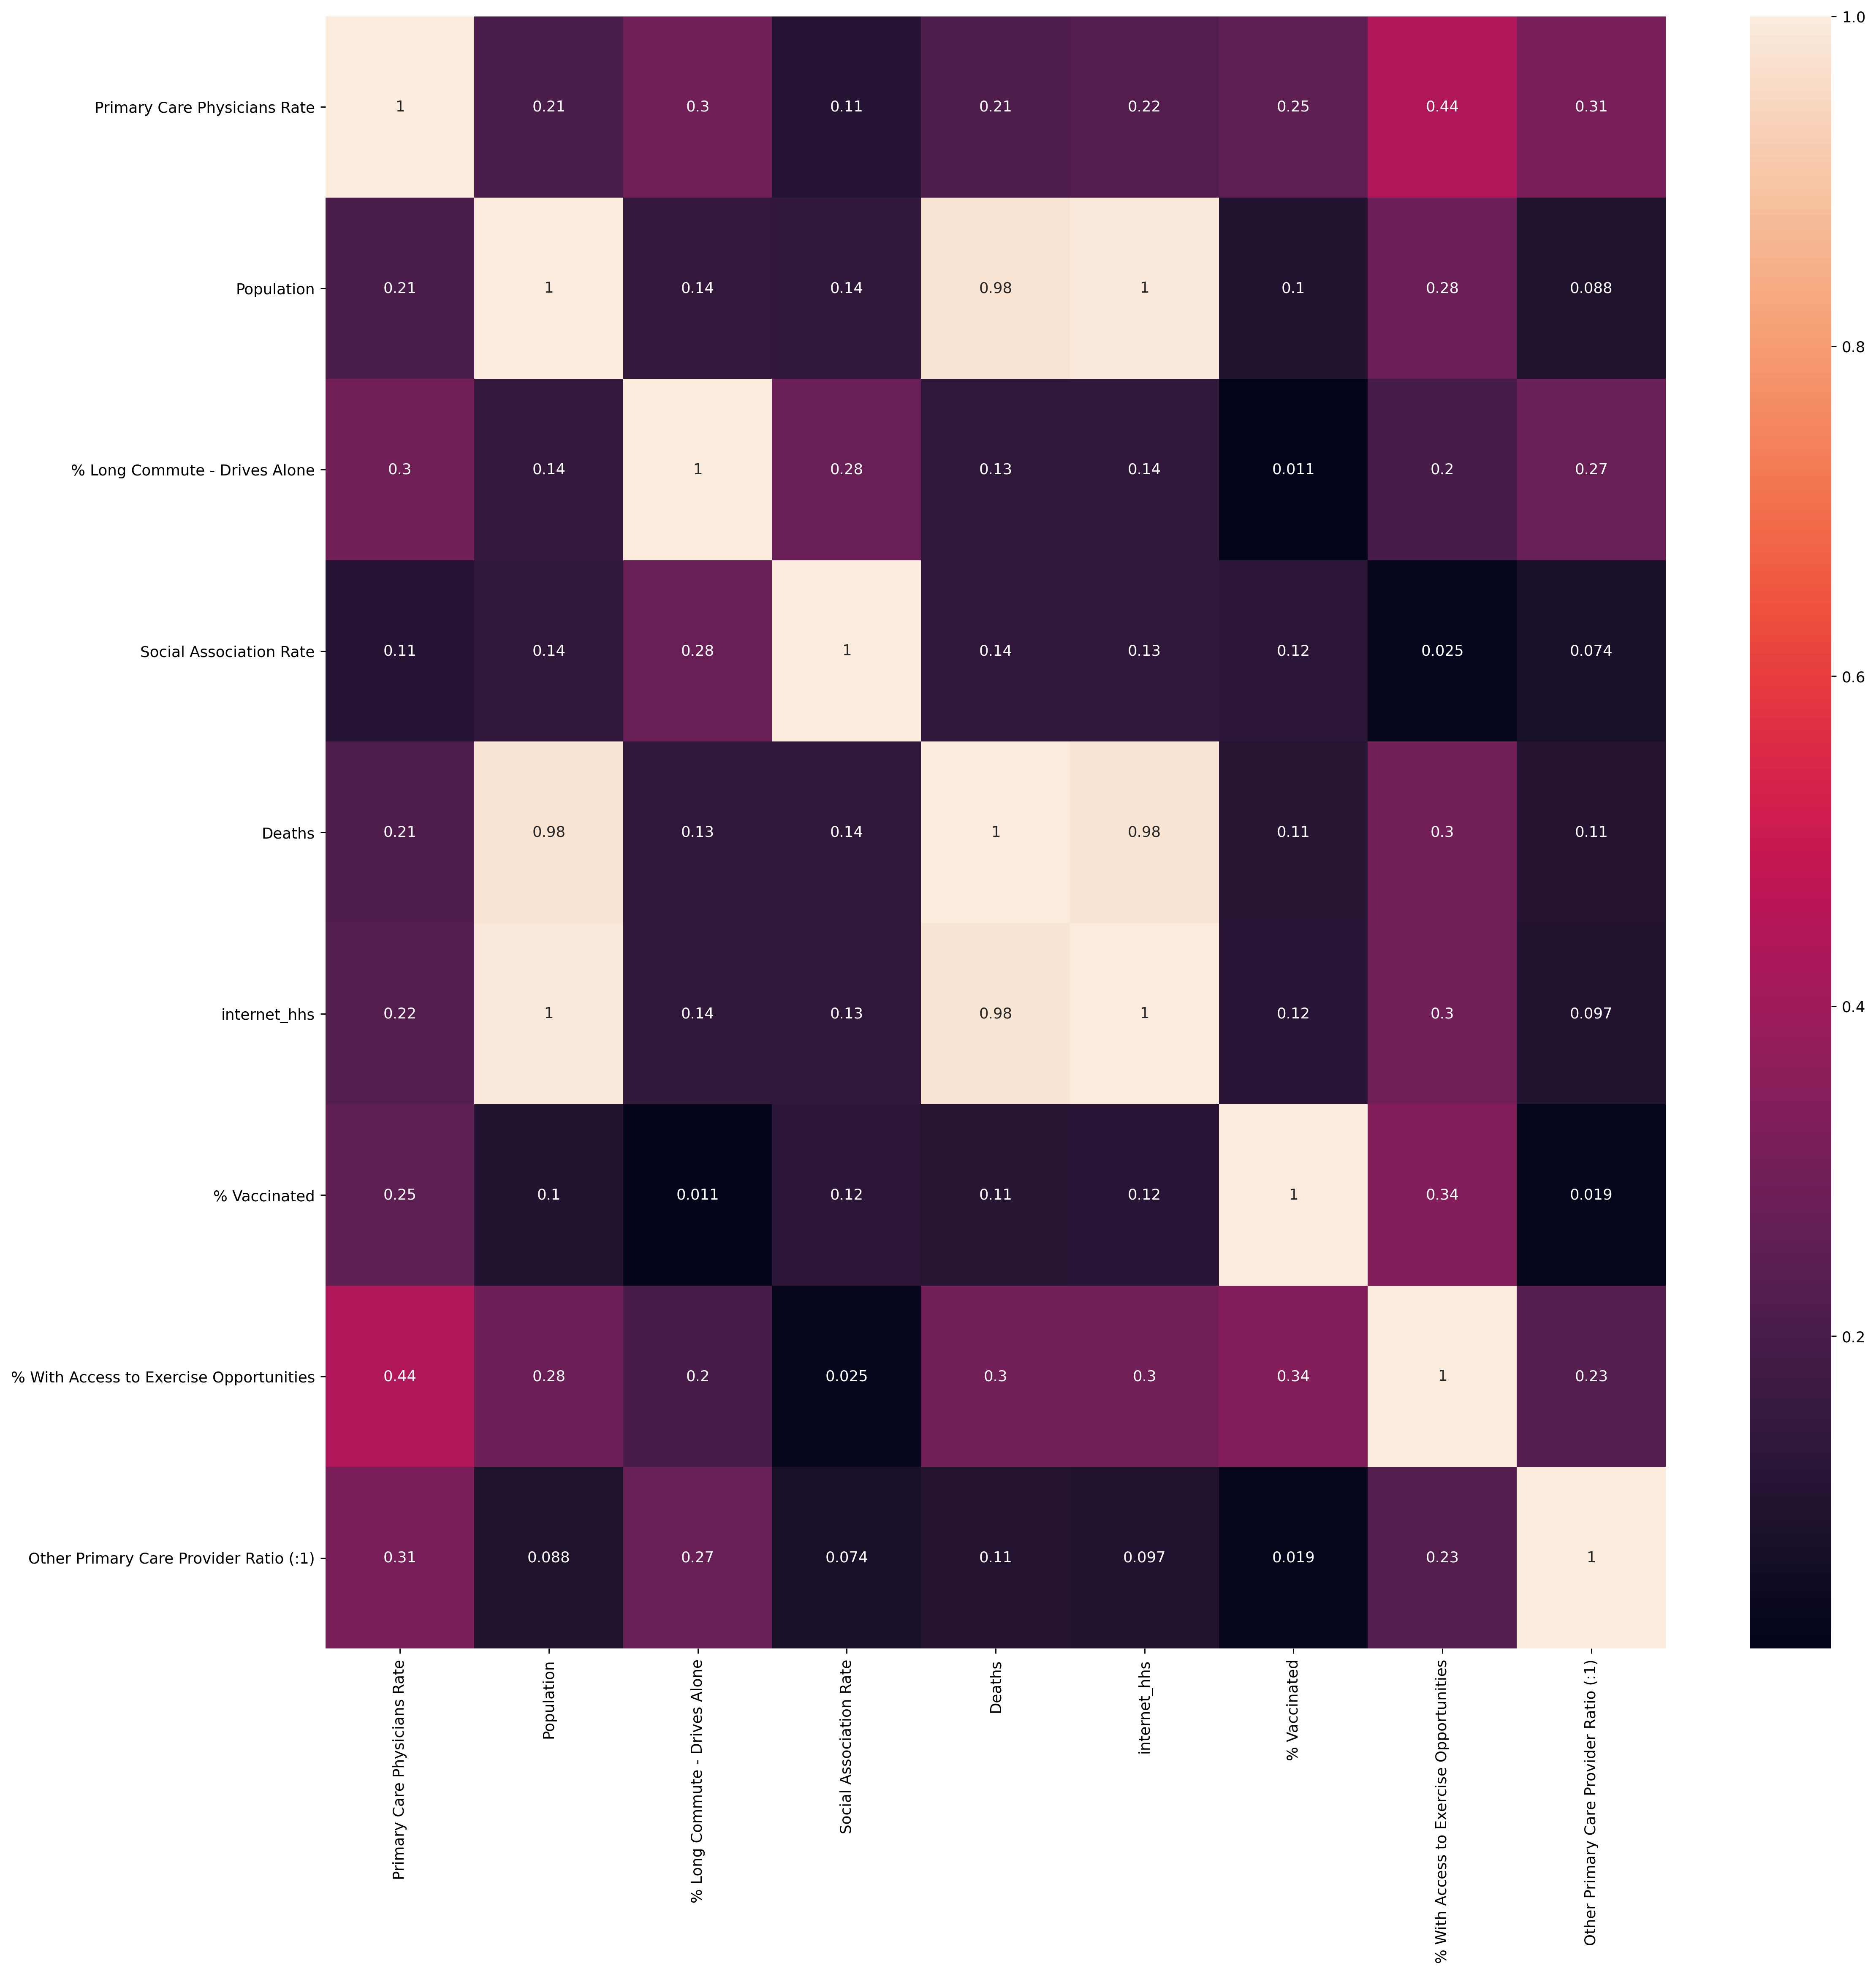

In [32]:
plt.figure(figsize=[20,20],dpi=256)
sns.heatmap(Correlation_Matrix, annot=True)

plt.show()

In [33]:
plt.figure(figsize=[20,20],dpi=400)
a = pps.matrix(X_x).pivot(columns='x', index='y', values='ppscore')
sns.heatmap(a, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
plt.show()